<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 2
---------------------------------------------------------------
Student numbers: <span style="color:red">r0708518, r0927391, r0925509, r0924356, r0912639</span>.

# 1. Introduction and overview
This assignment consists of *three main parts*:
* Image classification (Section 2)
* Semantic segmentation (Section 3)
* Adversarial attacks (Section 4)

In the first part, we train an end-to-end neural network for image classification. In the second part, we do the same for semantic segmentation. In the third part, we try to find and exploit the weaknesses of our classification and/or segmentation network. Finally, we reflect and produce an overall discussion with links to the lectures and "real world" computer vision (Section 5).

## 1.1 Deep learning
We start by loading the required packages for our notebook. We rely on [Tensorflow](https://www.tensorflow.org/) to build our deep learning architectures. A crash course on Tensorflow can be found [here](https://colab.research.google.com/drive/1UCJt8EYjlzCs1H1d1X0iDGYJsHKwu-NO).

In [55]:
# Default packages
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import cv2
from PIL import Image
from tqdm.notebook import tqdm
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [56]:
# Deep learning specific packages
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.backend import argmax
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras import backend as keras
import keras.losses
from keras import regularizers #fixing overfitting with L2 regularization
import keras.backend as K
from keras.preprocessing.image import *

from skimage.transform import resize
from sklearn.model_selection import train_test_split

import gc
import pickle

Since training deep learning models is tedious and computationally expensive, we saved the weights of our models to a Kaggle dataset. In case one wants to train the models either way, toggle the next boolean.

In [57]:
TRAIN_MODELS = False
LOAD_WEIGHTS = False

## 1.2 PASCAL VOC 2009
For this project, we will consider data from the [PASCAL VOC 2009](http://host.robots.ox.ac.uk/pascal/VOC/voc2009/index.html) dataset. The goal of using this dataset is to recongize objects embedded into realistic scenes, meaning that the images are not preprocessed to pre-segmented objects. Therefore, it is a supervised learning problem where the input data are images and the output data are the labels of the objects that are present in the image. There are twenty different objects present in the dataset:
* Person: person
* Animal: bird, cat, cow, dog, horse, sheep
* Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
* Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor

In this first section, we will consider the **classification** part of the competition, where the goal is to predict the presence/absence of a class in the images of the test set. In the second section, we consider the **segmentation** part of the competition, where the goal is instead to generate pixel-wise segmentations that determine the class of the object visible at each pixel (or whether the pixel is belonging to the background). 

Let us start by loading the data provided by the Kaggle competition.

In [58]:
# Loading the training data
train_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train/train_set.csv', index_col="Id")
labels = train_df.columns[0:20]
labels_str = labels.tolist()
train_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

The training set contains 749 examples.


In [59]:
# Loading the test data
test_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/test/test_set.csv', index_col="Id")
test_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
print("The test set contains {} examples.".format(len(test_df)))

The test set contains 750 examples.


Before we jump into the problem it is advised to consider the provided data and their meaning. The first row of the dataset is shown below:

In [60]:
train_df.head(1)

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,img,seg
Id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,"[[[10, 8, 13], [16, 14, 19], [17, 14, 21], [19...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


 The given dataframes contain 22 columns, where the first 20 correspond to the classes that are present in the Pascal VOC dataset. A value of $0$ denotes that the corresponding object is not present in the image, while a value of $1$ indicates that the object is present in the image.

As an extra, we use a colormap based on the labels of the Pascal dataset:

In [61]:
# Get discrete colorbar
cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
pascal_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
pascal_norm = mpl.colors.BoundaryNorm(np.arange(0.5,20+1), cmap.N) 

The remaining two columns provide the image and the segmentations. The segmentations have the same 2D shape as the images, but have only one channel. Here, the "pixels" consist of integers between 0 and 20, and denote whether a pixel is part of an object of the labels. We demonstrate this with an example:

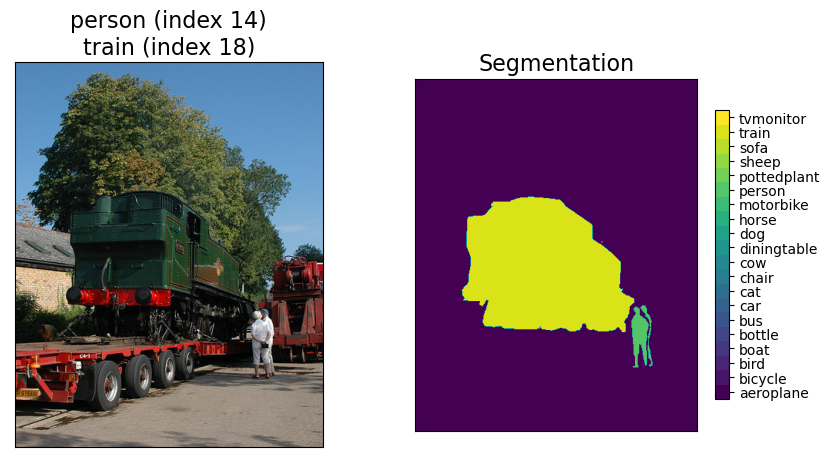

In [62]:
# Get an example image
ind = 7
example_img = train_df.loc[ind]["img"]
example_seg = train_df.loc[ind]["seg"]
# Show the image and the segmentation
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1, ax2 = axs

# Show the picture
ax1.imshow(example_img)
ax1.set_title("\n".join(f"{label} (index {np.argwhere(labels==label)[0][0]})" for label in labels if train_df.iloc[ind][label] == 1), fontsize=16)

# Show segmentation with colorbar
im = ax2.imshow(example_seg, cmap=pascal_cmap, norm=pascal_norm)
cbar = fig.colorbar(im, ax=ax2, shrink=0.75, ticks=np.linspace(1, 20, 20))
cbar.ax.set_yticklabels(labels)
ax2.set_title("Segmentation", fontsize=16)

# Remove ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

It can also be convenient to see the **class distribution** in the provided dataset. Since images can have several class labels attached to them, as the example above shows, we just count the number of occurences of each class in the provided dataset and divide it by the size of the dataset, to see the percentage of occurence of each label. As the plot shows, there are a lot of images with persons. The other classes are more or less balanced balanced in distribution.

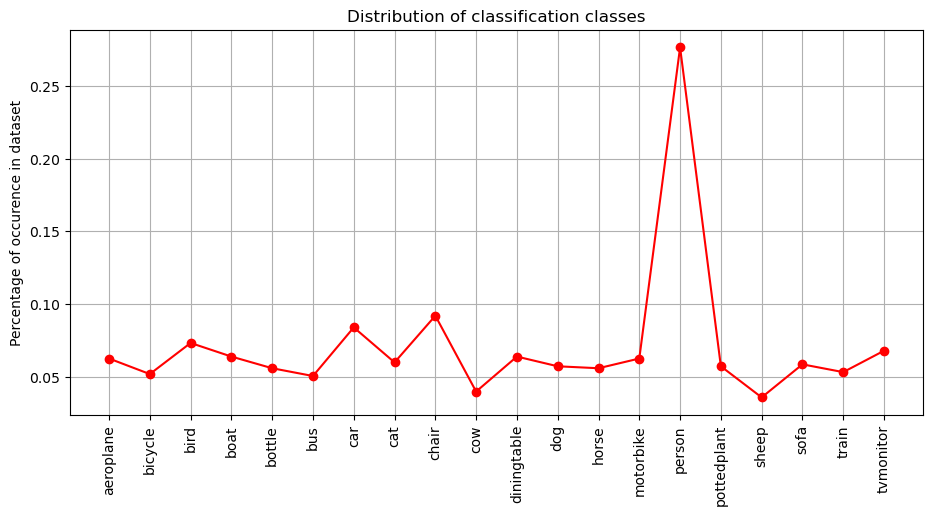

In [63]:
# Get class distributions
class_distr = np.array([np.sum(train_df[lab]) for lab in labels])/len(train_df)
# Plot it
plt.figure(figsize=(11,5))
xt = [i for i in range(len(class_distr))]
plt.plot(xt, class_distr, "-o", color="red")
plt.xticks(xt, labels=labels, rotation=90)
plt.ylabel("Percentage of occurence in dataset")
plt.title("Distribution of classification classes")
plt.grid()
plt.show()

We now do the same for the segmentation

In [64]:
def counts_seg(df):
    seg_distr = np.zeros(21)
    total_nb_pixels = 0
    for seg in df["seg"]:
        # Get the counts of the segmentation pixels:
        unique, counts = np.unique(seg, return_counts=True)
        # Add counts to correct class
        for i, label in enumerate(unique):
            seg_distr[label] += counts[i]
        # Add size of image (pixels)
        total_nb_pixels += len(seg.flatten())
    # Divide by counts by total nb pixels for probabilities
    return seg_distr/total_nb_pixels

Apply to our dataframe:

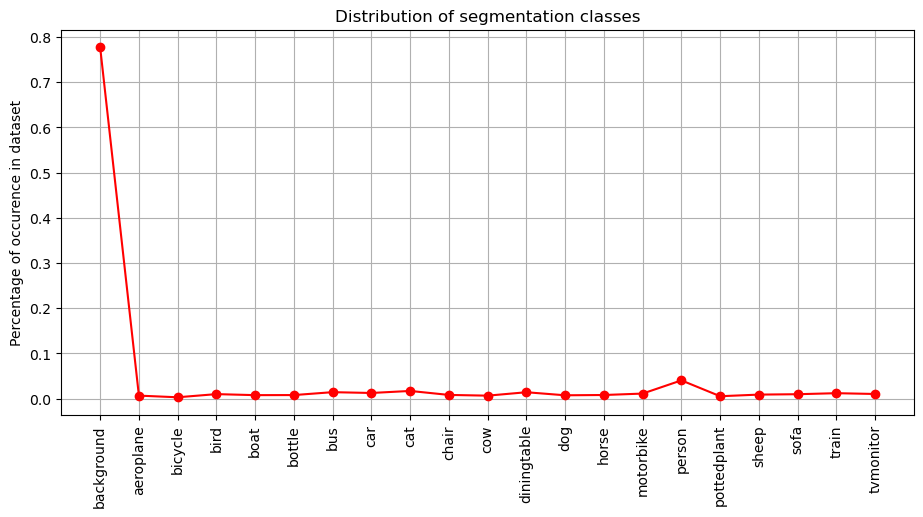

In [65]:
# Get segmentation pixels
seg_distr = counts_seg(train_df)
# Plot
plt.figure(figsize=(11,5))
xt = [i for i in range(len(seg_distr))]
plt.plot(xt, seg_distr, "-o", color="red")
all_labels = ["background"] + labels.tolist()
plt.xticks(xt, labels=all_labels, rotation=90)
plt.ylabel("Percentage of occurence in dataset")
plt.title("Distribution of segmentation classes")
plt.grid()
plt.show()

In [66]:
print(seg_distr)

[0.77741799 0.00672085 0.00305846 0.01004579 0.00777677 0.00794284
 0.01436016 0.01257319 0.01707563 0.00826569 0.00665399 0.01421591
 0.00744796 0.00809063 0.01124268 0.04044935 0.00538749 0.00897975
 0.00983566 0.01211208 0.01034711]


## 1.3 Utilities
Below, we define a few auxiliary functions. First, we define functions to simplify generating the Kaggle submission:

In [67]:
def _rle_encode(img):
    """
    Kaggle requires RLE encoded predictions for computation of the Dice score (https://www.kaggle.com/lifa08/run-length-encode-and-decode)

    Parameters
    ----------
    img: np.ndarray - binary img array
    
    Returns
    -------
    rle: String - running length encoded version of img
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle

def generate_submission(df):
    """
    Make sure to call this function once after you completed Sect. 2 and Sect. 3! It transforms and writes your test dataframe into a submission.csv file.
    
    Parameters
    ----------
    df: pd.DataFrame - filled dataframe that needs to be converted
    
    Returns
    -------
    submission_df: pd.DataFrame - df in submission format.
    """
    df_dict = {"Id": [], "Predicted": []}
    for idx, _ in df.iterrows():
        df_dict["Id"].append(f"{idx}_classification")
        df_dict["Predicted"].append(_rle_encode(np.array(df.loc[idx, labels])))
        df_dict["Id"].append(f"{idx}_segmentation")
        df_dict["Predicted"].append(_rle_encode(np.array([df.loc[idx, "seg"] == j + 1 for j in range(len(labels))])))
    
    submission_df = pd.DataFrame(data=df_dict, dtype=str).set_index("Id")
    submission_df.to_csv("submission.csv")
    return submission_df

We also define an auxiliary function to reshape images using OpenCV:

In [68]:
def reshape_images(images, size):
    """
    Simple auxiliary function to reshape a given sequence of images to the square shape (size, size).
    Parameters
    ----------
    images: list, np.array - Array of images to be resized.
    size: int - Size along one dimension of the final images. Shape will be (size, size).
    
    Returns
    -------
    new_images_array: np.array -  Resized images inside a numpy array
    
    """
    new_images = []
    # Resize each image in the given sequence
    for img in images:
        resized = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
        new_images.append(resized)
    # Convert from list to array
    new_images_array = np.array(new_images)
    return new_images_array

In [69]:
def show_training(history, loss_key = "loss", acc_key = "accuracy"):
    """
    Plots the training of a Keras model, based on the history provided by the fit methods.
    """
    train_loss  = history[loss_key]
    val_loss    = history["val_" + loss_key]
    train_acc   = history[acc_key]
    val_acc     = history["val_" + acc_key]
    epochs_list = np.linspace(1, len(train_loss), len(train_loss))

    # Make a plot
    plt.subplots(nrows=1, ncols=1, figsize=(12, 3))

    plt.subplot(121)
    plt.plot(epochs_list, train_loss, '-o', color="red", label="Train")
    plt.plot(epochs_list, val_loss, '-o', color="blue", label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.yscale('log')
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs_list, train_acc, '-o', color="red", label="Train")
    plt.plot(epochs_list, val_acc, '-o', color="blue", label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid()

    plt.show()

Utility function which plots an image from the training set (by specifying its index) as well as the output of the model to check its behaviour at prediction time.

In [70]:
def test_classification(model, img_index, threshold=0.5, verbose=True):
    """
    Tests a classification model by making predictions on a specific image.

    Args:
        model (ClassificationModel): The trained classification model.
        img_index (int): The index of the image to be tested.
        threshold (float, optional): The threshold for class probability. Default is 0.5.

    """
    # Get image & correct label(s)
    img = X_train[img_index]  # Fetch the image from the training set
    input_img = np.expand_dims(img, axis=0)  # Add an extra dimension for batch processing
    true_label = labels[y_train[img_index] == 1].tolist()  # Get the true label(s) from the training labels

    # Make prediction with threshold
    pred = model(input_img)[0]  # Get the predicted class probabilities for the input image
    pred_indices = np.argwhere(pred > threshold)  # Find the indices where the probabilities exceed the threshold

    # Convert to strings
    pred_label = np.array(labels.tolist())[pred_indices].flatten()  # Convert the predicted indices to their corresponding labels

    # Print results
    if verbose:
        print(f"Correct   label(s): {true_label}")
        print(f"Predicted label(s): {pred_label}")

    # Plot image and prediction distribution
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(img)
    title = ""
    plt.title(true_label)
    plt.xticks([])
    plt.yticks([])

    # Plot distribution
    plt.subplot(122)
    xt = [i for i in range(len(pred))]
    plt.plot(xt, pred, "-o", color="red")
    plt.xticks(xt, labels=labels, rotation=90)
    plt.ylabel("Probability")
    plt.grid()
    plt.axhline(threshold, ls="--", color="black")

    plt.show()


# 2. Image classification

### Preprocessing:

First, we reshape the images into the desired shape that all the architectures use. We then have 749 train images of size $(224, 224)$ as this is the input dimension that all our architectures use. Each training image has a corresponding label which is a one-hot encoded vector of size 20.

In [71]:
X_train = reshape_images(train_df["img"], 224)
y_train = np.asarray(train_df[train_df.columns[:20]])
X_test = reshape_images(test_df["img"], 224)
print(f"Shape of X_train is {X_train.shape}")
print(f"Shape of y_train is {y_train.shape}")
print(f"Shape of X_test  is {X_test.shape}")

Shape of X_train is (749, 224, 224, 3)
Shape of y_train is (749, 20)
Shape of X_test  is (750, 224, 224, 3)


## 2.0 Introduction and overview


As already mentioned, this first section will deal with the classification task of the Pascal VOC dataset. The goal is to implement a deep learning architecture, namely a **convolutional neural network** (CNN), and train it to recognise all the 20 classes of the dataset, as shown for instance in the example image above. The CNN should process the image on the left and correctly predict the presence of the train and person class for that image. Before we delve into the code, we provide an overview and explanation of the different set-ups we have considered for this work, to keep the discussion compact and organized. We considered different architectures, and trained each architecture on three different mechanisms. 

### 2.0.1 Architectures

The first architecture we consider is **MobileNetV2**, developed at Google [1]. The architecture is simple and makes use of bottleneck residual blocks besides the conventional convolutional and pooling layers. These consist of a sequence of three layers. The first is a $1 \times 1$ 2D convolutional layer with a ReLU6 activation function ($\text{ReLU6}(x) = \min\left( \max\left( 0, x \right), 6 \right)$). The second is a $3 \times 3$ depthwise convolutional layer, again with ReLU6 activation function. A *depthwise separable convolution* factorizes the standard convolutional operator into two layers. The first layer is a depthwise convolution which uses a single convolutional filter per input channel. The second layer performs a pointwise convolution, with kernel size $1 \times 1$, to build new features. The advantage of these operators is that their computational cost is 8 to 9 times smaller than standard convolutions, at only a small reduction in the accuracy. The final part of the bottleneck residual block uses a linear $1\times 1$ convolutional layer. Overall, MobileNetV2 has less parameters than MobileNetV1 (discussed below).

The precise architecture is shown below. First, a regular convolution is applied. Then, several linear bottleneck layers, discussed in detail in the paper, are applied. Finally, after the image has been downsampled to a $7\times 7$ image with 1280 kernels, an averaging pool is used to get a vector of $1280$ features which can then be processed into a classifier. Below, we flatten the output layer (to go from shape $1\times 1 \times 1280$ to shape $1280$) and process these features into a classifier. 
<figure style="text-align: center;">
    <img src=https://miro.medium.com/v2/resize:fit:1016/1*5iA55983nBMlQn9f6ICxKg.png>
    <figcaption>The MobileNetV2 architecture.</figcaption>
</figure>

The second architecture we investigate is **VGG16** [2]. The novel insight that this paper put forward was that significant improvements in the accuracy can be achieved by increasing their depth by adding more convolutional layers, which is made feasible by using very small $3 \times 3$ convolutional filters in all layers, which is the smallest receptive field that can capture the notions of left/right and down/up. The network uses standard ReLU activation functions. The drawback of the architecture is that it is over 533MB, which makes deploying VGG a tiresome task [3]. Smaller network architectures can therefore be desirable. VGG16 outperformed state-of-the-art models at its time of introduction in the ILSVRC-2012 and ILSVRC-2013 competitions. The architecture is shown below:
<figure style="text-align: center;">
    <img src="https://miro.medium.com/v2/1*NNifzsJ7tD2kAfBXt3AzEg.png" width=75%>
    <figcaption>The VGG16 architecture.</figcaption>
</figure>

The third architecture we consider is the **InceptionV3** [4]. It addressed the computational complexity of deep models such as VGG16 and came up with a way to easily scale up such models to larger sizes. The key insight that this paper used is that larger convolutional filters, such as $5\times 5$ or $7\times 7$, while much more expensive to evaluate, can capture dependencies between signals further away. In order to still use such larger kernels but without an increased computation time, the idea was to replace these convolutions with a multi-layer network with less parameters but the same input and output sizes. For instance, a $5 \times 5$ convolutional layer can be replaced by a two layers of $3 \times 3$ convolutions. This reduces the number of parameters by sharing the weights between the adjacent tiles. This leads to a $28\%$ relative gain in computation time. Besides, the model was trained using label-smoothing regularization. That is, instead of having a fixed "ground truth" label, the label is replaced by a distribution which represents a mixture between the original ground truth distribution and a fixed distribution. This prevents the largest logit of the network to become much larger than all other logits, which may result in better generalization.  

<figure style="text-align: center;">
    <img src="https://pytorch.org/assets/images/inception_v3.png">
    <figcaption>The InceptionV3 architecture.</figcaption>
</figure>


The final architecture that we consider is **MobileNet**, the predecessor of the first architecture that we discussed [5]. This original architecture also made use of depthwise separable convolution, explained above. Further details are found in the paper.
<figure style="text-align: center;">
    <img src="https://www.researchgate.net/publication/331675538/figure/fig2/AS:735605247967235@1552393366382/layers-of-MobileNet-architecture-4.ppm" width=30%>
    <figcaption>MobileNetV1 architecture.</figcaption>
</figure>

### 2.0.2 Training mechanisms

Furthermore, each architecture was trained with three different **training mechanisms**.

First, we consider the case of **transfer learning**. These classes implement pre-trained models for image classification by loading pre-trained weights from the ImageNet dataset. It allows us to leverage their performance and apply it to our specific classification task on images from the Pascal VOC dataset. After loading the architectures, we modify them by replacing the fully connected layers at the end of the network with a new flattened layer of the final output, and we add a dense (*i.e.*, fully connected) layer with a sigmoid activation function. This final layer has 20 output nodes, such that it is compatible with the Pascal VOC dataset which has 20 classes.

Second, we consider **transfer learning with fine-tuning**. Here, we allow to fine-tune the architecture on top of the transfer learning. These classes also use transfer learning as before, and hence much of the code will be similar to the previous class. However, now we include an additional step called **fine-tuning**. After the modified model is trained with the initial hyperparameters, the layers of the base models are unfrozen, allowing them to be trained along with our custom layers. This fine-tuning step aims to further improve the base model's performance by allowing the lower layers to learn more specific features from our new dataset. This allows us to get more flexibility in the model and can yield a more capable network.

Third, we consider training the architectures **from scratch**. This means that we do not import any weights from pre-trained models, but instead train the entire model on our own dataset.

### 2.0.2 Training set-up and hyperparameters

The training of all classification models generally use more or less the same **set-up and hyperparameters**. We have chosen for the **Adam optimizer** and a **cross-entropy loss**. In Adam, derived from “adaptive moments” one computes an unbiased estimate for the first and second moments of the gradient. Adam is generally regarded as fairly robust to the choice of hyperparameters. Details can be found in Section 8.5.3 of the book [*Deep Learning*](https://www.deeplearningbook.org/) by Goodfellow *et al.*. The cross-entropy loss **TODO discuss** 

The model is trained for around 20 to 30 epochs on the Pascal VOC dataset. We use a small learning rate of around $10^{-5}$ as this empirically gave good results. We make us of early stopping to prevent overfitting, with patience of around $3$ epochs and threshold improvement of $0.01$. For this, we use a train-validation split, and use $20\%$ of the dataset as validation data. We also process the training data in batches of size $32$.


**References:**

[1] Sandler, M., Howard, A., Zhu, M., Zhmoginov, A., & Chen, L. C. (2018). *Mobilenetv2: Inverted residuals and linear bottlenecks*. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4510-4520).

[2] Simonyan, K., & Zisserman, A. (2014). *Very deep convolutional networks for large-scale image recognition*. arXiv preprint arXiv:1409.1556.

[3] Neurohive. (2018, November 20). VGG16 - Convolutional Network for Classification and Detection. Retrieved May 16, 2023, from https://neurohive.io/en/popular-networks/vgg16/

[4] Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). *Rethinking the inception architecture for computer vision*. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).

[5] Howard, A.G., Zhu, M., Chen, B., Kalenichenko, D., Wang, W., Weyand, T., Andreetto, M. and Adam, H. (2017). *Mobilenets: Efficient convolutional neural networks for mobile vision applications*. arXiv preprint arXiv:1704.04861.

## 2.1 Results

The results of the different architectures are shown below. We see that the best results are obtained with MobileNetV2 and that, in general, transfer learning and finetuning give the best results. This is to be expected, since transfer learning allows us to essentially import architectures that have been trained for a much longer time on much more images. By importing the first layers of these pretrained models, we can use networks that already are able to extract relevant features from the images. We also expect fine-tuning to give additional improvements, since this final stage allows us to retrain the entire architecture, such that we are made sure that the pretrained layers and our custom-defined dense layer(s) are properly working together. Moreover, we notice from the figure that training these models from scratch can already give quite a high performance, which is also pretty consistent across the different architectures. Finally, the VGG16 architecture has remarkably a lower performance than all the other models.

Below, we will work with **InceptionV3**, as we found this model slightly easier to work with.

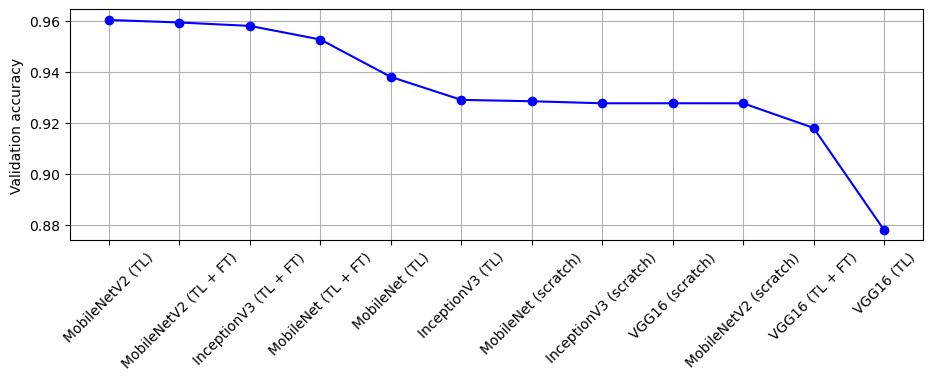

In [72]:
with open('/kaggle/input/cv-ga2-class-results/sorted_classification_names.pickle', 'rb') as handle:
    classification_names = pickle.load(handle)
    
with open('/kaggle/input/cv-ga2-class-results/sorted_classification_val_accs.pickle', 'rb') as handle:
    classification_val_accs = pickle.load(handle)
    
xticks = [i for i in range(len(classification_names))]

plt.figure(figsize=(11,3))
plt.plot(xticks, classification_val_accs, '-o', color="blue")
plt.xticks(xticks, labels=classification_names, rotation=45)
plt.grid()
plt.ylabel("Validation accuracy")
plt.show()

## 2.2 Final model: InceptionV3 (transfer learning + fine-tuning)

The final model is shown below. After the layers of InceptionV3, we add a custom layer that finally has 20 output nodes and which uses a sigmoid activation function, such that the output falls between 0 and 1 such that it can be interpreted as a probability. Actual predictions of the model are then obtained by taking $0.5$ as a threshold: if the output of a certain node is above this threshold, then the model predicts that this class is present in the image. In principle, one can essentially view this threshold value as yet another hyperparameter, which can then be tuned on a separate validation set. However, this goes beyon the scope of this project, and we are also quite satisfied with the current performance of the model.

In [73]:
class ClassificationModel:
    def __init__(self, X, y):
        """
        Initializes a ClassificationModel object.

        Args:
        
            X (numpy.ndarray): Input image data with shape (num_samples, height, width, channels).
            y (numpy.ndarray): Target labels with shape (num_samples, num_classes).

        """
        # Load pre-trained InceptionV3 model
        base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
        base_model.trainable = False

        # Add custom layers on top of the base model
        new_l = tf.keras.layers.Flatten()(base_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        model = tf.keras.Model(base_model.input, new_l)

        # Preprocess the input data
        X_train = tf.keras.applications.inception_v3.preprocess_input(X)

        # Compile the model
        model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-4),
                      loss='binary_crossentropy', metrics=['binary_accuracy'])
        
        # Set up callbacks for training
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=3, min_delta=0.01),
            tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_binary_accuracy", save_best_only=True)
        ]
        
        # Train the model with the pre-training settings
        pre_history = model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.pre_history = pre_history

        # Enable fine-tuning of the base model
        base_model.trainable = True
        model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-8),
                      loss='binary_crossentropy', metrics=['binary_accuracy'])
        
        # Train the model with fine-tuning
        history = model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.model = model
        self.history = history

    def predict(self, X):
        """
        Predicts the class probabilities for input images.

        Args:
            X (numpy.ndarray): Input image data with shape (num_samples, height, width, channels).

        Returns:
            numpy.ndarray: Predicted class probabilities with shape (num_samples, num_classes).

        """
        preprocessed_X = tf.keras.applications.inception_v3.preprocess_input(X)
        return self.model.predict(preprocessed_X, verbose=0)

    def __call__(self, X):
        """
        Makes predictions using the model.

        Args:
            X (numpy.ndarray): Input image data with shape (num_samples, height, width, channels).

        Returns:
            numpy.ndarray: Predicted class probabilities with shape (num_samples, num_classes).

        """
        return self.predict(X)


### 2.2.1 Training the model

First, we train the model (or load in the training from the memory) and discuss the learning curves we obtained.

In [74]:
if TRAIN_MODELS:
    classification_model = ClassificationModel(X_train, y_train)

In [75]:
%%capture
if not TRAIN_MODELS:
    with open('/kaggle/input/cv-ga2-class-results/classification_model.pickle', 'rb') as handle:
        classification_model = pickle.load(handle);

In [76]:
## To save the trained model:
# with open('/kaggle/working/classification_model.pickle', 'wb') as handle:
#     pickle.dump(classification_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

Here, we show the final training epochs for our chosen InceptionV3 model, which was trained with transfer learning and fine-tuning. The top part shows the transfer learning part, the bottom shows the fine-tuning stage. We notice that the model already has a quite high performance from the start and only requires a few iterations to improve to the accuracy reported above. Moreover, most of the improvement is made during transfer learning, where we increase the accuracy by another $~\sim 4\%$. Remarkably, the fine-tuning part has a wilder behaviour: even though the loss of the validation set was increasing during fine-tuning, the accuracy was increasing as well. We also observed that it is quite easy to overfit on the training data during fine-tuning, such that we chose for a very low learning rate. While this is not really observed for the run we show below (the training accuracy was even decreasing at first), it seems likely that we started overfitting in the final epoch.  

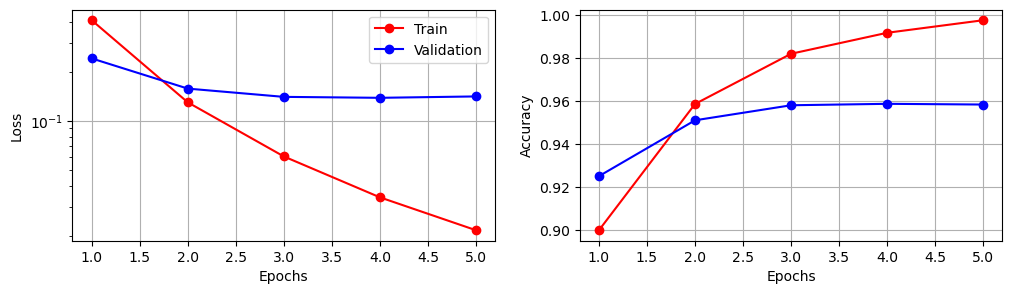

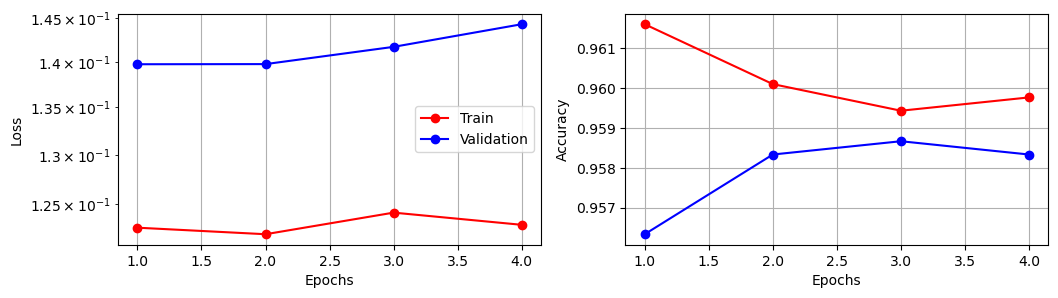

In [77]:
show_training(classification_model.pre_history.history, acc_key="binary_accuracy")
show_training(classification_model.history.history, acc_key="binary_accuracy")

### 2.2.2 Checking performance of the model

Even though we can use metrics and monitor the loss during training, it is often informative to check the predictions of the model and assess it qualitatively. Below, we show an example where the model is able to correctly predict all the classes present in an image:

Correct   label(s): ['bottle', 'person', 'sofa']
Predicted label(s): ['bottle' 'person' 'sofa']


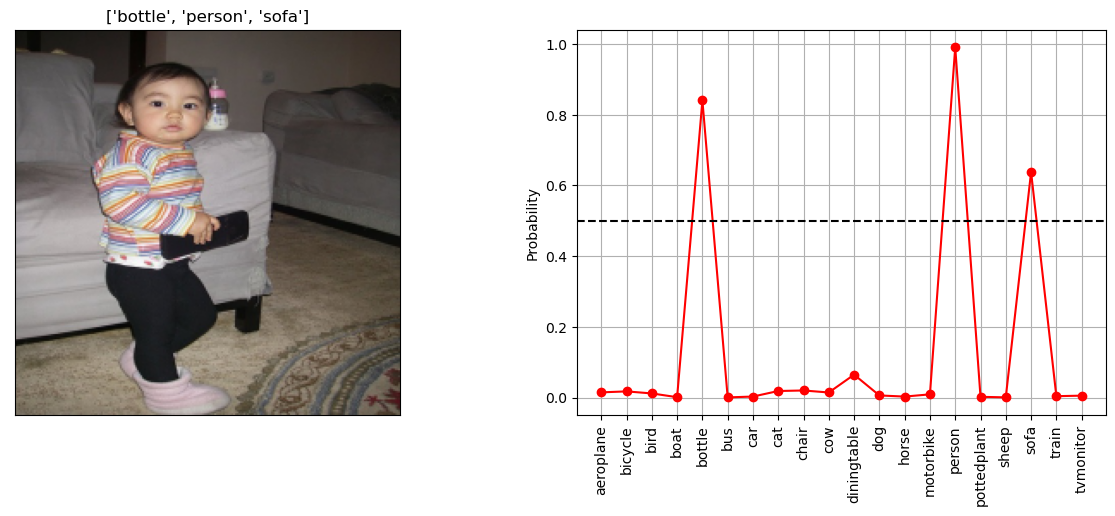

In [78]:
test_classification(classification_model, 15)

Here's an example where the model misses one of the classes present in the image. In this and other, similar "bad" predictions, the model has a high output value for the missing class, but since it is slightly below the threshold of 0.5, it does not predict the class in the final result. As already mentioned, it can be possible to improve the results by tuning this threshold, to reduce this kind of misclassifications from happening.

Correct   label(s): ['person', 'train']
Predicted label(s): ['train']


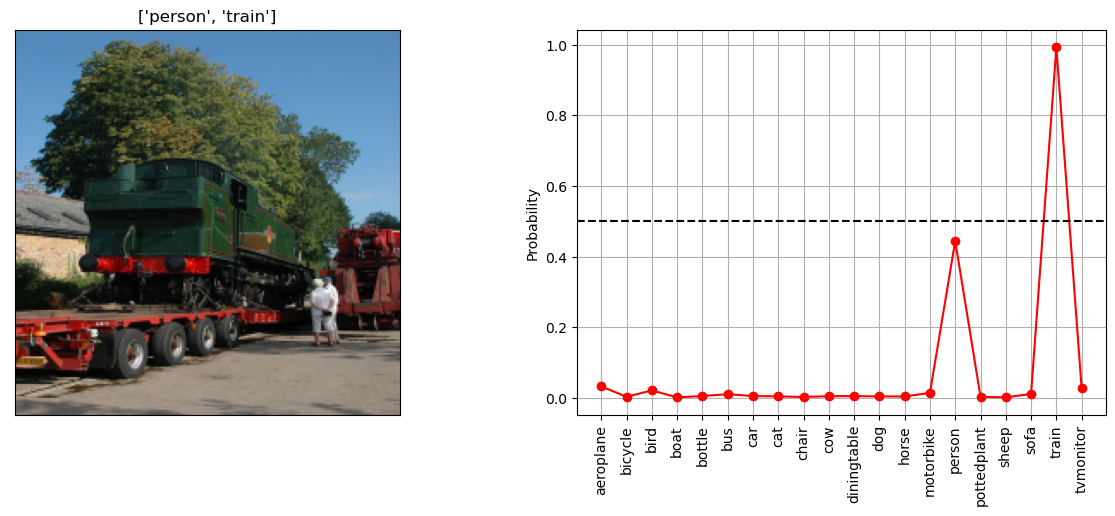

In [79]:
test_classification(classification_model, 7)

We define an auxiliary function that turns the predictions of the output layer into predictions suitable for the Kaggle competition

In [80]:
def predict_classes(model, img, threshold=0.5, verbose=False):
    """
    Predicts the classes of an input image using a classification model.

    Args:
        model (ClassificationModel): The trained classification model.
        img (numpy.ndarray): The input image.
        threshold (float, optional): The threshold for class probability. Default is 0.5.
        verbose (bool, optional): Whether to print the predicted labels. Default is False.

    Returns:
        numpy.ndarray: The predicted classes as binary values.
    """
    # Resize and reshape the image for TensorFlow
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
    img = np.expand_dims(img, axis=0)
     # Make prediction with threshold
    pred = model(img)[0]
    pred = np.where(pred > threshold, 1, 0)

    if verbose:
        pred_indices = np.argwhere(pred > threshold)
        # Convert the predicted indices to their corresponding labels
        pred_label = np.array(labels.tolist())[pred_indices].flatten()
        print(f"{pred_label} predicted")

    return pred

Here is an example of how the function works:

In [81]:
# pred = predict_classes(classification_model, train_df["img"][15], verbose=True)
# print(pred)

Generate Classification Outputs for Submission:
(this code takes some time to run)

In [82]:
for idx in range(len(X_test)):
    org_shape = X_test[idx].shape
    x = X_test[idx]
    d = predict_classes(classification_model, X_test[idx], verbose=False)
    test_df.at[idx, labels] = d

# 3. Semantic segmentation
The goal here is to implement a segmentation CNN that labels every pixel in the image as belonging to one of the 20 classes (and/or background). 

## 3.0 Data preprocessing and utilities

### 3.0.1 Preprocessing

For convenience, we again resize the images into shape $224 \times 224 \times 3$, and store these as new entries in the train dataframe.

In [83]:
# Resize training data
train_df['img_n'] = train_df["img"].map(lambda img:  cv2.resize(img, (224,224)))
train_df["seg"] = train_df["seg"].map(lambda img:  cv2.resize(img, (224,224), interpolation=cv2.INTER_NEAREST))
# Convert to arrays for compatibility with Keras
train_img_keras = np.array(train_df["img_n"].values.tolist())
train_seg_keras = np.array(train_df["seg"].values.tolist())

We perform a train-validation split:

In [84]:
X_train, X_test, y_train, y_test  = train_test_split(train_img_keras, train_seg_keras, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

We make use of the following auxiliary functions during preprocessing:

In [85]:
def augment(input_image, input_mask):
    """
    Augments an input image and its corresponding mask by randomly flipping them horizontally.

    Args:
        input_image (tf.Tensor): The input image tensor.
        input_mask (tf.Tensor): The input mask tensor.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: A tuple containing the augmented image and mask tensors.
    """
    if tf.random.uniform(()) > 0.5:
        # Randomly flip the image and mask horizontally
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask


def normalize(input_image, input_mask):
    """
    Normalizes an input image by dividing it by 255.0 and casts it to float32.

    Args:
        input_image (tf.Tensor): The input image tensor.
        input_mask (tf.Tensor): The input mask tensor.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: A tuple containing the normalized image and the original mask tensor.
    """
    # Normalize the input image by dividing it by 255.0 and cast it to float32
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

Preprocess the data. We make use of one-hot encoding.

In [86]:
num_classes = 21

In [87]:
# Train dataset
train_images_bc, train_labels_bc = (X_train, y_train.reshape(-1, 224,224,1))
train_labels_cat                 = to_categorical(train_labels_bc, num_classes=num_classes)
train_images, train_labels       = normalize(train_images_bc, train_labels_cat)
# Validation
val_labels_cat                   = to_categorical(y_val, num_classes=num_classes)
val_images, val_labels_cat       = normalize(X_val, val_labels_cat)
# Test
test_labels_cat                  = to_categorical(y_test, num_classes=num_classes)
test_images, test_labels_cat     = normalize(X_test, test_labels_cat)

In [88]:
print(f"Before one-hot encoding: {train_labels_bc.shape}")
print(f"After  one-hot encoding: {train_labels_cat.shape}")

Before one-hot encoding: (479, 224, 224, 1)
After  one-hot encoding: (479, 224, 224, 21)


### 3.0.2 Utilities

Some auxiliary functions are defined below

In [89]:
def test(m, img, i):
    """
    Predicts image classes and displays visualizations.

    This function takes an image and an index as input, performs prediction
    on the image using a pre-trained model, and displays visualizations of
    the image and the predicted classes.

    Args:
        img (numpy.ndarray): Input image array.
        i (int): Index of the image in the dataset.

    Returns:
        None
    """

    # Reshape the image to match the model's input shape
    x = img.reshape(-1, 224, 224, 3)

    # Perform prediction on the image using the pre-trained model
    d = m.predict(x)

    # Set a threshold for the predictions
    threshold = 0.55
    result = d > threshold

    # Extract the predicted class labels from the predictions
    imclass = np.argmax(result, axis=3)[0, :, :]

    # Print the unique class labels in the predicted classes
    print(np.unique(imclass))

    # Create a figure to display the visualizations
    plt.figure(figsize=(15, 7))

    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(np.asarray(img))

    # Plot the predicted classes
    plt.subplot(1, 3, 2)
    plt.imshow(imclass)

    # Plot the original image again
    plt.subplot(1, 3, 3)
    plt.imshow(np.asarray(img))

    # Mask the predicted classes where the label is 0
    masked_imclass = np.ma.masked_where(imclass == 0, imclass)

    # Uncomment the following lines if you want to overlay the masked classes
    # on the original image or the predicted classes
    # plt.imshow(imclass, alpha=0.5)
    # plt.imshow(masked_imclass, alpha=0.5)

    # Uncomment the following lines if you have the 'train_labels_cat' array
    # and want to visualize the true class labels
    # test_labels = train_labels_cat.reshape(224, 224)
    # real_class = np.argmax(test_labels[25], axis=3)[0, :, :]
    # print(np.unique(np.argmax(test_labels_cat[i], axis=2)))
    # plt.imshow(np.argmax(test_labels_cat[i], axis=2))

We define a few functions which we use to build our models:

In [90]:
def double_conv_block(x: tf.Tensor, n_filters: int):
    """
    Creates a double convolutional block consisting of two Conv2D layers with ReLU activation.

    Args:
        x (tf.Tensor): The input tensor.
        n_filters (int): The number of filters (output channels) for the Conv2D layers.

    Returns:
        tf.Tensor: The output tensor after passing through the double convolutional block.
    """
    # Conv2D layer with n_filters filters, 3x3 kernel, 'same' padding, ReLU activation, and 'he_normal' initializer
    x = Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    # Conv2D layer with n_filters filters, 3x3 kernel, 'same' padding, ReLU activation, and 'he_normal' initializer
    x = Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    return x

def downsample_block(x: tf.Tensor, n_filters: int, dropout: float = 0):
    """
    Creates a downsample block consisting of a double convolutional block, max pooling, and optional dropout.

    Args:
        x (tf.Tensor): The input tensor.
        n_filters (int): The number of filters (output channels) for the convolutional layers.
        dropout (float, optional): The dropout rate. Defaults to 0.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: A tuple containing the feature tensor after the double convolutional block (f),
        and the downsampled and optionally dropout-applied tensor (p).
    """
    # Apply double convolutional block to input tensor
    f = double_conv_block(x, n_filters)
    # Max pooling with 2x2 pool size
    p = MaxPooling2D((2, 2))(f)
    # Optional dropout layer with specified dropout rate (default: dropout of zero percentage)
    p = Dropout(dropout)(p)
    return f, p

def upsample_block(x: tf.Tensor, conv_features: tf.Tensor, n_filters: int, dropout: float = 0):
    """
    Creates an upsample block consisting of upsampling, concatenation, dropout, and double convolution.

    Args:
        x (tf.Tensor): The input tensor for upsampling.
        conv_features (tf.Tensor): The tensor from the corresponding downsample block for concatenation.
        n_filters (int): The number of filters (output channels) for the convolutional layers.
        dropout (float, optional): The dropout rate. Defaults to 0.

    Returns:
        tf.Tensor: The output tensor after the upsample block.
    """
    # Upsample using Conv2DTranspose with n_filters filters, 3x3 kernel, stride 2, and 'same' padding
    x = Conv2DTranspose(n_filters, 3, strides=2, padding="same")(x)
    # Concatenate the upsampled tensor with the corresponding downsample block's feature tensor
    x = concatenate([x, conv_features])
    # Optional dropout layer with specified dropout rate (default: rate 0)
    x = Dropout(dropout)(x)
    # Apply double convolutional block to the concatenated tensor
    x = double_conv_block(x, n_filters)
    return x


With the above auxiliary functions that define our upsampling and downsampling blocks, we are now going to recreate the **U-Net** architecture [1]. **TODO provide discussion**

**References:**

[1] Ronneberger, O., Fischer, P., & Brox, T. (2015). *U-net: Convolutional networks for biomedical image segmentation*. In Medical Image Computing and Computer-Assisted Intervention–MICCAI 2015: 18th International Conference, Munich, Germany, October 5-9, 2015, Proceedings, Part III 18 (pp. 234-241). Springer International Publishing.

## 3.1 U-Net

In [91]:
def unet(pretrained_weights = None, input_size = (224,224,3), weights= [1.,1.,1.,1.],\
         activation='relu', dropout=0, loss='categorical_crossentropy', optimizer='adam',\
             dilation_rate=(1,1), reg=0.01):
    """
    U-Net model for image segmentation. 

    Args:
    - pretrained_weights: (str) path to the saved pretrained weights of the model.
    - input_size: (tuple) input size of the image.
    - weights: (list) weights for loss function.
    - activation: (str) activation function for convolution layers.
    - dropout: (float) dropout rate.
    - loss: (str) loss function for model optimization.
    - optimizer: (str) optimizer for model optimization.
    - dilation_rate: (int) dilation rate for convolution layers.
    - reg: (float) regularization parameter.
    Returns:
    - unet_model: (tf.keras.Model) compiled U-Net model.
    """
    # input layer
    inputs  = Input(shape=input_size)
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = Conv2D(num_classes, 1, activation='softmax')(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model([inputs], [outputs], name="U-Net")
    # unet_model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

    if(pretrained_weights):
        # load saved pretrained weights
        print('Using {0} pretrained weights'.format(pretrained_weights))
        unet_model.load_weights(pretrained_weights)

    return unet_model


We define a new instance of the model and print the architecture we are using

In [92]:
new_model = unet()
opt = Adam(learning_rate=1e-3)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']
epochs = 100
steps_per_epoch = 30
new_model.compile(optimizer=opt, loss=loss, metrics=metrics)
new_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

### 3.1.1 Custom U-Net architecture, from scratch

First, we train the architecture defined above from scratch. **TODO check discussion** During training, this architecture leads to a large divergence between traininig and validation accuracy. It results in pixels from one class being classified as multiple different classes.

In [93]:
LOAD_WEIGHTS = True
if not LOAD_WEIGHTS:
    # Train the model
    history_scratch = new_model.fit(train_images, train_labels_cat, 
                        validation_data=(val_images, val_labels_cat), 
                        epochs=100, batch_size=32)
    # Save the obtained weights, to export to Kaggle datasets
    new_model.save('/kaggle/working/model_scratch')
    new_model.save('/downloads/vision_scratch_model')
else:
    # Download models from the dataset
    reconstructed_model_1 = keras.models.load_model('/kaggle/input/models/model_scratch/model_scratch')
    scratch_loss, scratch_acc = reconstructed_model_1.evaluate(test_images, test_labels_cat)
    print(f"The accuracy of the scratch model is {scratch_acc}")

5/5 [==============================] - 15s 2s/step - loss: 2.1825 - categorical_accuracy: 0.7252
The accuracy of the scratch model is 0.7251680493354797


In [94]:
# show_training(history_scratch.history)

After training, we want to obtain predictions by setting a threshold on the softmax output:

In [112]:
#test(np.asarray(reconstructed_model_1, test_images[1]),1)
#test(np.asarray(reconstructed_model_1, test_images[12]),12)
#test(np.asarray(reconstructed_model_1, test_images[33]),33)
#test(np.asarray(reconstructed_model_1, test_images[14]),14)
#test(np.asarray(reconstructed_model_1, test_images[22]),22)
#test(np.asarray(reconstructed_model_1, test_images[31]),31)

### 3.1.2 Keras U-Net architecture

In [96]:
!pip install -U -q segmentation-models
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

Segmentation Models: using `tf.keras` framework.


Now, we import the U-Net architecture that Keras implemented, and train it on our Pascal VOC dataset. 

In [97]:
num_classes = 21
LOAD_WEIGHTS = True
if not LOAD_WEIGHTS:
    # Define and train the model
    transfer_model = Unet(classes=num_classes)
    transfer_model.trainable = True
    transfer_model.compile('Adam', 'categorical_crossentropy', ['categorical_accuracy'])
    # Save the model
    transfer_model.save('/kaggle/working/model_scratch_keras')
    transfer_model.save('/downloads/vision_scratch_model_keras')
    history_unet_transfer = transfer_model.fit(train_images, train_labels_cat, 
                                          validation_data=(val_images, val_labels_cat), 
                                          epochs=95, batch_size=32)
else:
    reconstructed_model_2 = keras.models.load_model('/kaggle/input/models/model_scratch_keras/model_scratch_keras')
    loss, acc = reconstructed_model_2.evaluate(test_images, test_labels_cat)
    print(f"The Keras U-Net model trained from scratch has accuracy {acc}")

5/5 [==============================] - 2s 231ms/step - loss: 1.4339 - categorical_accuracy: 0.7716
The Keras U-Net model trained from scratch has accuracy 0.7715598344802856


In [99]:
transfer_loss, transfer_acc = reconstructed_model_2.evaluate(test_images, test_labels_cat)
print(f"The transfer model accuracy is {transfer_acc}")

5/5 [==============================] - 1s 127ms/step - loss: 1.4339 - categorical_accuracy: 0.7716
The transfer model accuracy is 0.7715598344802856


### 3.1.3 Transfer learning, Keras U-Net

 Here, we import the U-Net architecture as well as the weights. During training, this training accuracy very slowly improves. Some classes are not identified during testing (only background). However compared to the model trained from scratch, pixels from one object are not being classified as so many different classes anymore.

In [103]:
if TRAIN_MODELS:
    # Train the model
    inp = Input(shape=(None, None, 21))
    model4 = Unet(backbone_name='resnet34', classes=21, encoder_weights='imagenet')
    model4.compile('Adam', 'categorical_crossentropy', ['categorical_accuracy'])
    history_transfer = model4.fit(train_images, train_labels_cat, 
                                  validation_data=(val_images, val_labels_cat), 
                                  epochs=105, batch_size=32)
    # Save the weights
    model4.save('/kaggle/working/model_transfer_cat')
    model4.save('/downloads/vision_transfer_model_cat')
    
elif LOAD_WEIGHTS:
    reconstructed_model_3 = keras.models.load_model('/kaggle/input/models/model_transfer_cat/model_transfer_cat')
    loss, acc = reconstructed_model_3.evaluate(test_images, test_labels_cat)
    print(f"This model has accuracy {acc}")

5/5 [==============================] - 3s 154ms/step - loss: 1.1212 - categorical_accuracy: 0.8133
This model has accuracy 0.8132919073104858


### 3.1.4 Transfer learning, VGG16

In https://github.com/farakiko/ImageSegmentationPASCAL/blob/master/Code.ipynb we see VGG16 used for segmentation. This model results in the best score in the submission.

In [104]:
num_classes=21

base_model = VGG16(include_top=False, weights='imagenet',input_shape=(224, 224, 3))
base_model.trainable=False

vgg_model = Sequential()

vgg_model.add(base_model)
vgg_model.add(Conv2D(4096, (7, 7), activation='tanh',
                padding='same'))
vgg_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
vgg_model.add(Dropout(0.5))
vgg_model.add((Conv2D(4096, (1, 1), activation='tanh',
                padding='same')))
vgg_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
vgg_model.add(Dropout(0.5))
vgg_model.add(Conv2D(num_classes,  (1, 1), kernel_initializer='he_normal'))
vgg_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
vgg_model.add(Conv2DTranspose(num_classes, kernel_size=(32, 32),  strides=(32, 32), use_bias=False))
vgg_model.add(Activation('softmax'))

58889256/58889256 [==============================] - 0s 0us/step


In [105]:
if TRAIN_MODELS:
    opt = Adam(lr=0.001)
    loss = 'categorical_crossentropy'
    metrics = ['categorical_accuracy']
    epochs = 100
    steps_per_epoch = 80
    vgg_model.compile(optimizer=opt, loss=loss, metrics=metrics)
    history = vgg_model.fit(train_images, train_labels_cat, 
                                      validation_data=(val_images, val_labels_cat), 
                                      epochs=110, batch_size=16)
    vgg_model.save('/kaggle/working/model_vgg')

In [106]:
LOAD_WEIGHTS=True
if LOAD_WEIGHTS:
    reconstructed_model_5 = keras.models.load_model('/kaggle/input/models/model_vgg_2/model_vgg')
    loss, acc = reconstructed_model_5.evaluate(test_images, test_labels_cat)
    print(f"This model has accuracy {acc}")

5/5 [==============================] - 2s 260ms/step - loss: 0.9279 - categorical_accuracy: 0.7915
This model has accuracy 0.7915355563163757


1/1 [==============================] - 1s 640ms/step
[ 0 15]
1/1 [==============================] - 0s 23ms/step
[0 6]
1/1 [==============================] - 0s 23ms/step
[0 1]
1/1 [==============================] - 0s 25ms/step
[ 0  8 14]
1/1 [==============================] - 0s 22ms/step
[ 0 10 13]
1/1 [==============================] - 0s 23ms/step
[ 0 11]


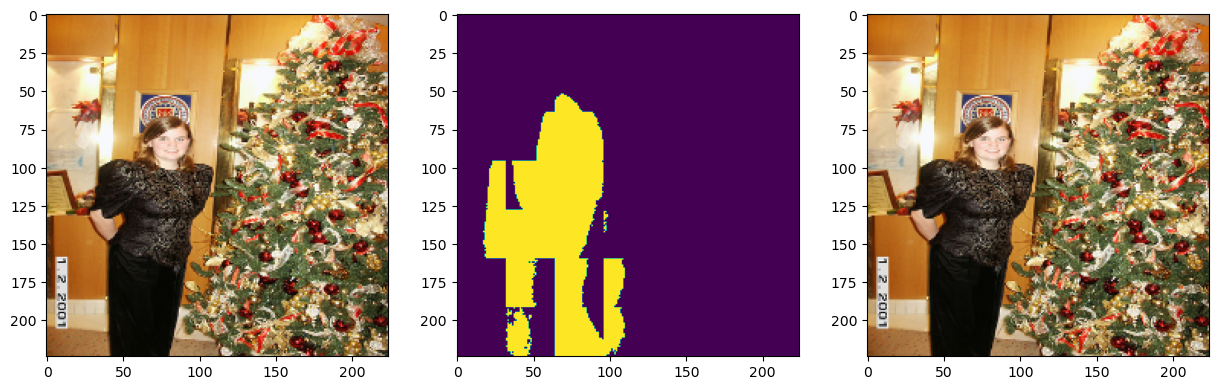

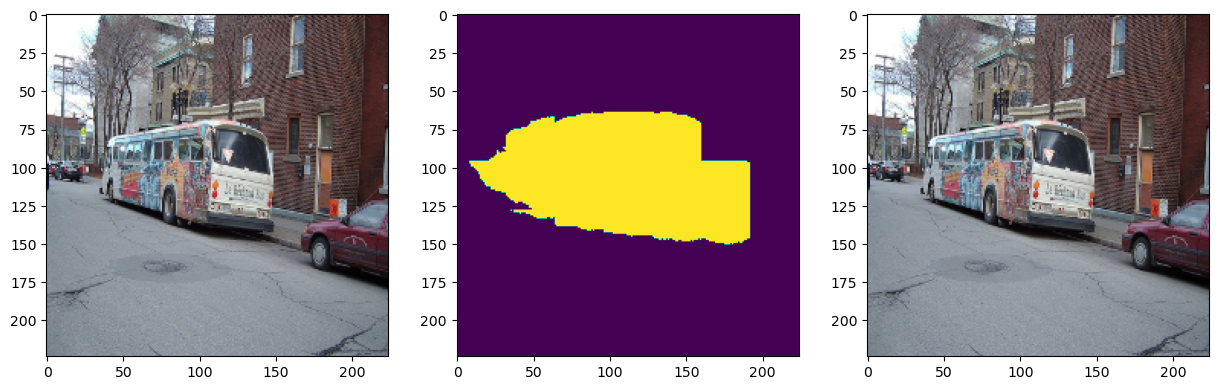

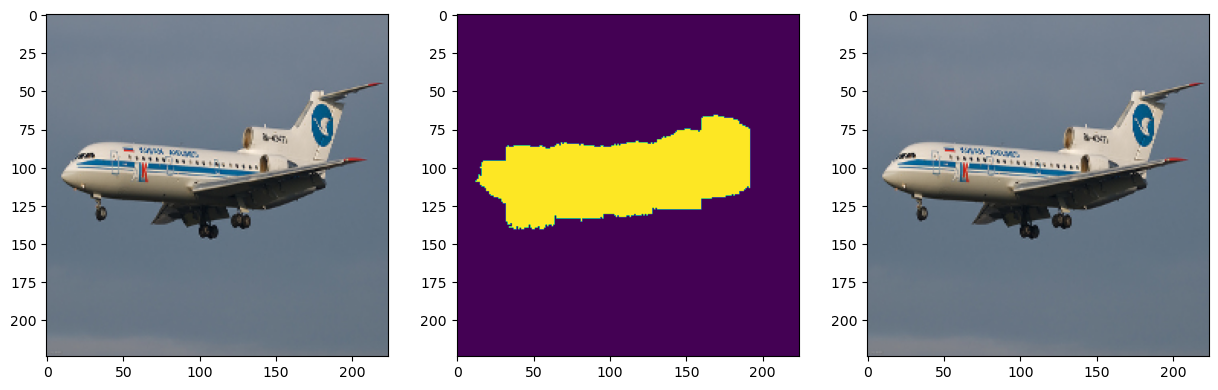

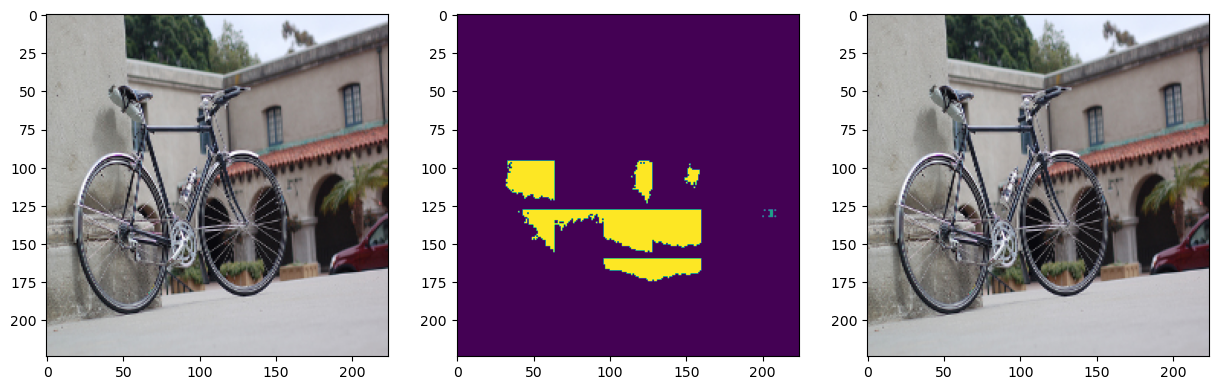

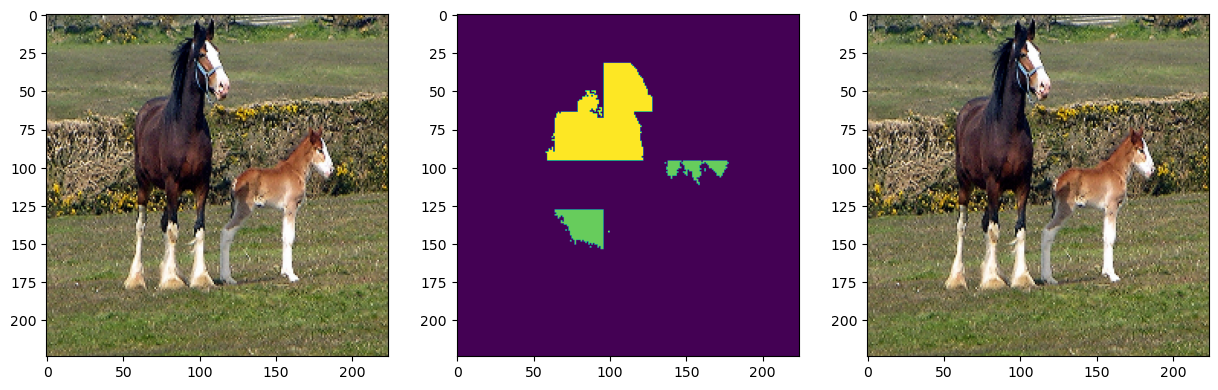

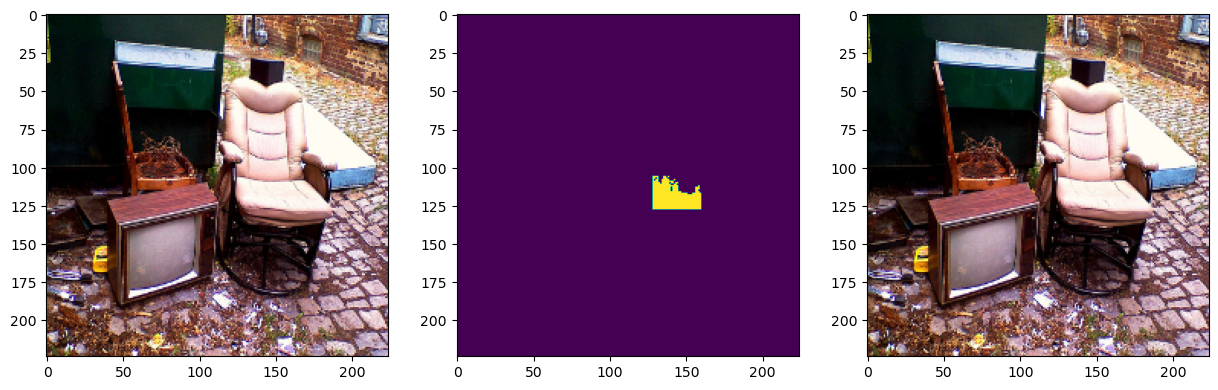

In [107]:
test(reconstructed_model_5, np.asarray(test_images[1]),1)
test(reconstructed_model_5, np.asarray(test_images[12]),12)
test(reconstructed_model_5, np.asarray(test_images[33]),33)
test(reconstructed_model_5, np.asarray(test_images[14]),14)
test(reconstructed_model_5, np.asarray(test_images[22]),22)
test(reconstructed_model_5, np.asarray(test_images[31]),31)

## 3.2 Prepare for submission

We prepare the testing data for submission, and apply the same preprocessing steps to it:

In [108]:
test_df['img_n'] = test_df["img"].map(lambda img:  cv2.resize(img, (224,224)))
test_img_keras = np.array(test_df["img_n"].values.tolist())
test_norm = tf.cast(test_img_keras, tf.float32) / 255.0

Next, we load in our favoured 

In [109]:
model_ = keras.models.load_model('/kaggle/input/models/model_vgg_2/model_vgg')

In [110]:
for idx in range(len(test_norm)):
    org_shape = test_norm[idx].shape
    x = test_norm[idx]
    x=tf.reshape(x, [-1,224,224,3])
    d = model_.predict(x)
    result=d>0.55# setting the threshold
    imclass = np.argmax(result, axis=3)[0,:,:]
    imclass_re = cv2.resize(np.asarray(imclass, dtype='uint8'),(test_df.at[idx, "seg"].shape[0],test_df.at[idx, "seg"].shape[1]))
    test_df.at[idx, "seg"] = cv2.resize(np.asarray(imclass, dtype='uint8'),(test_df.at[idx, "seg"].shape[0],test_df.at[idx, "seg"].shape[1]))

1/1 [==============================] - 0s 30ms/step


## Submit to competition
You don't need to edit this section. Just use it at the right position in the notebook. See the definition of this function in Sect. 1.3 for more details.

In [111]:
generate_submission(test_df)

,Predicted
Id,
0_classification,9 1 15 1
0_segmentation,
1_classification,9 1 11 1 16 1
1_segmentation,97038 1 97042 1 99109 1 99536 1 99928 1 99938 ...
2_classification,
...,...
747_segmentation,58699 1 58702 1 59452 1 59826 1 60189 1 60564 ...
748_classification,15 1
748_segmentation,83910 12 85786 1 86160 1 86534 1 86547 1 86908...


# 4. Adversarial attack

In this part, we are going to implement an adversarial attack on one of our models.

## 4.1 Formulation of the attack

Our task is to perturb an image such that our classification model predicts, with high confidence, that there is a horse and a person in the image while there is actually only an airplane present.

We tried two different approaches to orchestrate the attack. The first approach we considered was the **Fast Gradient Signed Method** (FGSM). **TODO discussion**

However, the FGSM was too rudimentary to reach high confidences in the network for the target label (we are performing a targeted attack not just changing the prediction label). Therefore, we decided to switch to the **Projected Gradient Descent** (PGD) instead. 

Reasons to choose PGD over FGSM:

- FGSM is designed to be fast but not optimal (the perturbation we get may be large for the effect on the confidence it has).
- It is easy to do untargeted attacks with FGSM but it is harder for targeted attacks (we would have to search the appropiate epsilon parameter).

**References:** We followed [this tutorial](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm) to implement FGSM but later changed to a custom PGD implementation following [this example](https://adversarial-ml-tutorial.org/) from Zico Kolter and Aleksander Madry. The Tensorflow code is inspired by [this link](https://github.com/cleverhans-lab/cleverhans).

In line of the context of adversarial attacks, which often happen after training and when the model is deployed in the real world ("in the wild"), we consider a random image found on the internet containing an airplane. We preprocess it and deliver it to our classification model. As expected, the model is able to accurately predict the presence of the airplane.

In [ ]:
!wget https://i.insider.com/62dcfe205bf4820019b5ece7?width=700 -O airplane.webp

In [ ]:
# Read the image file in its raw format
image_raw = tf.io.read_file('airplane.webp')

# Decode the raw image into a tensor
orig_image = tf.image.decode_image(image_raw)

def preprocess(image):
    """
    Preprocesses the image tensor for classification.

    Args:
        image (tf.Tensor): Input image tensor.

    Returns:
        tf.Tensor: Preprocessed image tensor.
    """
    # Resize the image to our chosen size
    image = tf.image.resize(image, (224, 224))

    # Preprocess the image using the InceptionV3 preprocessing function
    image = tf.keras.applications.inception_v3.preprocess_input(image)

    # Add a batch dimension to the image tensor (single image per batch)
    image = image[None, ...]

    return image

In [ ]:
# Preprocess and predict:
preprocessed_image = preprocess(orig_image)
pred = classification_model.model.predict(preprocessed_image, verbose=False)[0]
# Get predicted label(s) and convert to string
pred_indices = np.argwhere(pred > 0.5)
pred_label = np.array(labels.tolist())[pred_indices].flatten()

# Print results
print(f"Correct   label(s): aeroplane")
print(f"Predicted label(s): {pred_label}")

# Plot image and prediction distribution
plt.subplots(1, 2, figsize=(10, 3))
plt.subplot(121)
plt.imshow(preprocessed_image[0])
plt.title("aeroplane")
plt.xticks([])
plt.yticks([])

# Plot distribution
plt.subplot(122)
xt = [i for i in range(len(pred))]
plt.plot(xt, pred, "-o", color="red")
plt.xticks(xt, labels=labels, rotation=90)
plt.ylabel("Probability")
plt.grid()
plt.axhline(0.5, ls="--", color="black")

plt.show()

## 4.2 Loss function and gradient for the attack

We will now start building our attack on the network. We implement the PGD, explained in detail above:

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
def compute_gradient(input_image, target_label):
    """
    Computes the adversarial gradient that minimizes the loss from the image towards the target label.

    Args:
        input_image (tf.Tensor): Input image tensor.
        target_label (tf.Tensor): Target label tensor with shape (1, label_id).

    Returns:
        tf.Tensor: The adversarial gradient that minimizes the loss from the image towards the target label.
    """
    with tf.GradientTape() as tape:
        # Record the gradient operations happening inside this tape context
        tape.watch(input_image)
        
        # Forward pass
        prediction = classification_model.model(input_image)

        # We're trying to **minimize** the distance between the target (adversarial) label
        # and the predicted label, which is why we use a negative sign in the loss.
        # Note: Regularization is not added to the loss function here as we will be
        # regularizing the perturbation (the gradient) later on.
        loss = -loss_fn(target_label, prediction)

    # Backward pass
    # Compute the derivative of the loss with respect to the input image
    gradient = tape.gradient(loss, input_image)

    return gradient

In [ ]:
def normalize_gradient(grad, alpha_norm):
    """
    Normalizes the gradient using L2 normalization along each dimension of the image.

    Args:
        grad (tf.Tensor): Input gradient tensor.
        alpha_norm (float): Scaling factor for the normalized perturbation.

    Returns:
        tf.Tensor: Normalized perturbation.
    """
    axis = list(range(1, len(grad.get_shape())))  # [1,2,3]

    # Separately normalize each gradient dimension of the image using the 'axis'
    optimal_perturbation = tf.math.l2_normalize(grad, axis=axis)

    return alpha_norm * optimal_perturbation

def projected_gradient_descent(image, alpha_norm, epochs, target_label):
    """
    Applies the projected gradient descent method to generate an adversarial image.

    Args:
        image (np.ndarray): Input image array.
        alpha_norm (float): Scaling factor for the normalized perturbation.
        epochs (int): Number of optimization steps.
        target_label (tf.Tensor): Target label tensor with shape (1, label_id).

    Returns:
        np.ndarray: Adversarial image generated by the projected gradient descent method.
        np.ndarray: Accumulated perturbation during the optimization process.
    """
    perturbation_sum = np.zeros(image.shape)

    img_delta = image

    for _ in range(epochs):
        grad = compute_gradient(img_delta, target_label)
        optimal_perturbation = normalize_gradient(grad, alpha_norm)
        img_delta = img_delta + optimal_perturbation

        perturbation_sum = perturbation_sum + optimal_perturbation

    return img_delta, perturbation_sum

In [ ]:
def display_images(adversarial_image, description, perturbations, original_label, original_confidence):
    """Auxiliary function for plotting the adverserial attack for visualization."""
    origFigSize = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = [15, 3]
    plt.figure()

    # 1 - Original image
    plt.subplot(1,4,1)
    plt.imshow(*preprocessed_image)
    plt.title(f'Original \n {original_label} : {original_confidence}')
    plt.xticks([])
    plt.yticks([])
    
    # 2 - The perturbations
    plt.subplot(1,4,2)
    plt.imshow(*(perturbations*10))
    plt.title(f'{description}')
    plt.xticks([])
    plt.yticks([])

    # 3 - The adversarial image and predictions
    plt.subplot(1,4,3)
    plt.imshow(*(adversarial_image))
    plt.xticks([])
    plt.yticks([])

    # Get the prediction of the model for the title
    adv_image_probs = classification_model.model.predict(adversarial_image, verbose=0)[0]
    adv_pred_indices = np.argwhere(adv_image_probs > threshold)
    adv_image_probs = np.round(adv_image_probs, 2)
    adv_pred_label = np.array(labels.tolist())[adv_pred_indices].flatten() 
    plt.title(f'Adversarial \n {adv_pred_label} : {adv_image_probs[adv_pred_indices].flatten()}')
    
    # 4 - Show distributions
    plt.subplot(1,4,4)
    xt = [i for i in range(len(adv_image_probs))]
    plt.plot(xt, adv_image_probs, "-o", color="red")
    plt.xticks(xt, labels=labels, rotation=90)
    plt.ylabel("Probability")
    plt.grid()
    plt.axhline(0.5, ls="--", color="black")
    
    plt.show() 
    plt.rcParams['figure.figsize'] = origFigSize

In [ ]:
NUM_CLASSES = 20
threshold = 0.5

# Get prediction labels
pred_indices = np.argwhere(image_probs > threshold)
pred_label = np.array(labels.tolist())[pred_indices].flatten()
image_probs = np.round(image_probs, 2)

categ_encoder_layer = tf.keras.layers.CategoryEncoding(
          num_tokens=NUM_CLASSES, output_mode="multi_hot")

# Target labels are horse and person:
target_label = categ_encoder_layer([12, 14])

# Create a batch with a single image label
target_label = tf.reshape(target_label, (1, NUM_CLASSES))

## 4.3 Applying the adversarial attack

Now that we built the appropriate loss function and the PGD method, let's see how this perturbations affects the original image of the airplane and whether the changes are actually perceptible. The perturbations are magnified below for visualization purposes: we note that this does not mean that it is actually visible by humans when not magnified.

In [ ]:
# Decrease me to hide the perturbation trading off target confidence
alphas = [0.01, 0.1, 0.5]
descriptions = [f'Perturbation (magnified x10) \n L2 norm α = {a:0.2f}' for a in alphas]

# Increase me to get a more accurate estimation of the perturbation
EPOCHS = 40

for i, eps in enumerate(alphas): 
    adv_x, perturbations = projected_gradient_descent(preprocessed_image, eps, EPOCHS, target_label)
    display_images(adv_x, descriptions[i], perturbations, str(pred_label), str(image_probs[pred_indices].flatten()))

## 4.4 Discussion

We now present a discussion regarding the adversarial attack we implemented.

One could ask **whether such a white-box attack is realistic**. While most models are currently released as black-box models, a possible leak of model weights (in the case of propietary models) or the increasing usage of open source models with pretrained weights would definitely pose a threat for the security of those systems. Once the attacker identified the model and weights used, the attacker would be able to replicate the enviroment and craft adversarial inputs such that systems, which are not designed to be protected against such attacks, would be vulnerable, even when sitting behind an opaque API. This is also really important now that larger models are being released and not everyone is capable (by money or time constraints) of retraining the weights. While adversarial attacks were discussed here in the context of computer vision, we note that similar dangers exist in other AI fields employing deep learning. Large language models can similarly be misused in case their weights are leaked, and [the leak of Meta's LLaMa model a few months ago](https://www.theverge.com/2023/3/8/23629362/meta-ai-language-model-llama-leak-online-misuse) demonstrates that such a scenario can be turned into a reality.

Coming back to our attack, the **adversary was successful** in perturbing the images such that they changed the prediction of the model to the deceptive label with almost $100\%$ confidence, while still being clearly recognisable for a human observer by the original class. 

We remark that this means that the initial CNN that we trained is in some sense **unreliable**. At least it demonstrates that we should not trust the CNN blindly, and while chances are small that real-life images will disrupt the CNN, one should be prepared in case such an event happens. For instance, if a similar CNN was trained in a medical environment, inaccurate predictions can have drastic consequences. However, we do note that such an environment is likely less threatened by actual adversarial *attacks*, since it is likely that such models are not publicly accessible and there are fewer cases where attackers could benefit from such an attack. Moreover, patients themselves benefit from the model and its predictions, so they are likely not going to try to attack the model. 

To **increase the robustness** of the CNN to protect it against attacks, we do not think that there is a practical defense against all possible attacks when the attacker has the model weights, but a deterrent would be to keep the weights as private as possible. This is a vulnerability shared by all machine learning models that learn by optimisation and can not be ascribed to metrics such as accuracy or any other performance measure. However, we can defend the model from transfer attacks where the attacker only has similar weights or the architecture of the model. There is also the adversarial accuracy metric that tests whether a datapoint and its neighbouring datapoints have a similar prediction as it would be harder to find an adversarial input that maximises the loss. Furthermore, there exist benchmarking datasets online, which we could use to get an idea of how vulnerable our system is, in case we wish to deploy the model in real-life applications.

# 5. Discussion
Finally, take some time to reflect on what you have learned during this assignment. Reflect and produce an overall discussion with links to the lectures and "real world" computer vision.

# A. Classification architectures

Here, we provide the complete code that we used to compare different classification models. This appendix is divided into four parts, related to the different architectures (the architectures were discussed at the beginning of Section 2):
1. MobileNetV2 (Section A.1)
2. VGG16 (Section A.2)
3. InceptionV3 (Section A.3)
4. MobileNet (Section A.4)
5. Comparison between different architectures

Each section is further subdivided into three subsections, which are related to the different training mechanisms that we considered:

1. Transfer learning (Section A.X.1)
2. Transfer learning with fine-tuning (Section A.X.2)
3. Training the weights from scratch (Section A.X.3)

The specific architecture designs are shown at the beginning of each subsection. The details of the training, hyperparameter selection and a comparison between the training methods are discussed in Section A.1 for the MobileNetV2 architecture. The other sections make use of very similar set-ups and hyperparameter settings, so we only provide the necessary code there and readers are encouraged to read through Section A.1 for explanation. 

## A.1 MobileNetV2

### A.1.1 Transfer learning

In [ ]:
# Specify where the trained model should be saved:
SAVE_LOCATION = "/kaggle/working/mobv2_m1_best.h5"

class MobileNetV2_Model:
    """
    A class representing a MobileNetV2 model for image classification.

    Attributes
    ----------
    model : tf.keras.Model
        The MobileNetV2 model.

    Methods
    -------
    __init__()
        Initializes the MobileNetV2 model.
    fit(X, y)
        Trains the MobileNetV2 model with training images X and labels y.
    predict(X)
        Performs predictions using the MobileNetV2 model.
    __call__(X)
        Calls the predict() method.

    """

    def __init__(self):
        """
        Initializes the MobileNetV2 model.

        This function constructs a MobileNetV2 model with pre-trained weights from ImageNet.
        The fully connected layers of the original model are replaced with a new flattened layer
        and a dense layer with 20 units and sigmoid activation.

        """
        # Load in the MobileNetV2 architecture from Keras, use weights from Imagenet
        mobv2_model = tf.keras.applications.MobileNetV2(
            include_top=False,
            input_shape=(224, 224, 3),
            weights="imagenet"
        )

        # Freeze all layers of the MobileNetV2 model
        for l in mobv2_model.layers:
            l.trainable = False

        # Add new layer on top of the MobileNetV2 model to process our dataset
        new_l = tf.keras.layers.Flatten()(mobv2_model.output)
        new_l = tf.keras.layers.Dense(20, activation=OUT_ACTIVATION)(new_l)

        # Create a new model with the modified layers
        self.model = tf.keras.Model(inputs=mobv2_model.input, outputs=new_l)

    def fit(self, X, y):
        """
        Trains the MobileNetV2 model.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).
        y : np.array
            The target labels as a numpy array with shape (num_samples, num_classes).

        """
        X_train = tf.keras.applications.mobilenet_v2.preprocess_input(X)

        # Compile the model with settings for optimization and loss calculation
        self.model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-4),
            loss="binary_crossentropy",
            metrics=["binary_accuracy"]
        )

        # Set up callbacks for early stopping and saving the best model
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=SAVE_LOCATION,
                monitor="val_loss",
                save_best_only=True
            )
        ]

        # Train the model
        history = self.model.fit(
            X_train, y,
            epochs=30,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks
        )
        
        # Store the information obtained during training as field
        self.history = history

    def predict(self, X):
        """
        Performs predictions using the MobileNetV2 model.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).

        Returns
        -------
        np.array
            The predicted class probabilities as a numpy array with shape (num_samples, num_classes).

        """
        preprocessed_X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
        return self.model.predict(X, verbose=0)

    def __call__(self, X):
        """
        Calls the predict() method.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).

        Returns
        -------
        np.array
            The predicted class probabilities as a numpy array with shape (num_samples, num_classes).

        """
        preprocessed_X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
        return self.model.predict(X, verbose=0)


Now, define a new instance of the model, and train it on the Pascal VOC dataset:

In [ ]:
# Define an instance:
mobv2_m1 = MobileNetV2_Model()
## Show complete architecture -- lengthy output!
# mobv2_m1.model.summary()

In [ ]:
# Train on Pascal VOC dataset
mobv2_m1.fit(X_train, y_train)

We can visualize the training by plotting:

In [ ]:
show_training(mobv2_m1.history.history, acc_key="binary_accuracy")

### A.1.2 Transfer learning and finetuning

In [ ]:
SAVE_LOCATION = "/kaggle/working/mobv2_m2_best.h5"

class MobileNetV2_fine_Model:
    """
    A class representing a fine-tuned MobileNetV2 model for image classification.

    Attributes
    ----------
    model : tf.keras.Model
        The fine-tuned MobileNetV2 model.

    Methods
    -------
    __init__(X, y)
        Initializes and trains the fine-tuned MobileNetV2 model.
    predict(X)
        Performs predictions using the fine-tuned MobileNetV2 model.
    __call__(X)
        Calls the predict() method.

    """

    def __init__(self, X, y):
        """
        Initializes and trains the fine-tuned MobileNetV2 model.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).
        y : np.array
            The target labels as a numpy array with shape (num_samples, num_classes).

        """
        base_model = tf.keras.applications.MobileNetV2(
            include_top=False,
            input_shape=(224, 224, 3),
            weights="imagenet"
        )

        # Freeze all layers of the base MobileNetV2 model
        base_model.trainable = False

        # Add new layers on top of the base model
        new_l = tf.keras.layers.Flatten()(base_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)

        # Create the new model with the modified layers
        model = tf.keras.Model(base_model.input, new_l)

        X_train = tf.keras.applications.mobilenet_v2.preprocess_input(X)

        # Compile and train the model with the first set of hyperparameters
        model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-4),
            loss='binary_crossentropy',
            metrics=['binary_accuracy']
        )

        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, min_delta=0.001),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=SAVE_LOCATION,
                monitor="val_loss",
                save_best_only=True
            )
        ]

        pre_history = model.fit(
            X_train, y,
            epochs=20,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks
        )

        # Allow ALL layers of the base model to be trainable
        base_model.trainable = True

        # Compile and train the model with the second set of hyperparameters
        model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-6),
            loss='binary_crossentropy',
            metrics=['binary_accuracy']
        )

        history = model.fit(
            X_train, y,
            epochs=20,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks
        )

        self.model = model
        self.pre_history = pre_history
        self.history = history

    def predict(self, X):
        """
        Performs predictions using the fine-tuned MobileNetV2 model.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).

        Returns
        -------
        np.array
            The predicted class probabilities as a numpy array with shape (num_samples, num_classes).

        """
        preprocessed_X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
        return self.model.predict(preprocessed_X, verbose=0)

    def __call__(self, X):
        """
        Calls the predict() method.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).

        Returns
        -------
        np.array
            The predicted class probabilities as a numpy array with shape (num_samples, num_classes).

        """
        preprocessed_X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
        return self.model.predict(preprocessed_X, verbose=0)

In [ ]:
mobv2_m2 = MobileNetV2_fine_Model(X_train, y_train)

In [ ]:
show_training(mobv2_m2.pre_history.history, acc_key="binary_accuracy")
show_training(mobv2_m2.history.history, acc_key="binary_accuracy")

### A.1.3 Training from scratch

In [ ]:
SAVE_LOCATION = "/kaggle/working/mobv2_m3_best.h5"

class MobileNetV2_scratch_Model:
    """
    A class representing a MobileNetV2 model trained from scratch for image classification.

    Attributes
    ----------
    model : tf.keras.Model
        The MobileNetV2 model trained from scratch.

    Methods
    -------
    __init__()
        Initializes the MobileNetV2 model trained from scratch.
    fit(X, y)
        Trains the MobileNetV2 model on the given dataset.
    predict(X)
        Performs predictions using the MobileNetV2 model.
    __call__(X)
        Calls the predict() method.

    """

    def __init__(self):
        """
        Initializes the MobileNetV2 model trained from scratch.

        """
        mobv2_model = tf.keras.applications.MobileNetV2(
            include_top=False,
            input_shape=(224, 224, 3),
            weights=None
        )

        # Add new layers on top of the MobileNetV2 model
        new_l = tf.keras.layers.Flatten()(mobv2_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)

        # Create the model with the modified layers
        self.model = tf.keras.Model(inputs=mobv2_model.input, outputs=new_l)

    def fit(self, X, y):
        """
        Trains the MobileNetV2 model on the given dataset.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).
        y : np.array
            The target labels as a numpy array with shape (num_samples, num_classes).

        """
        X_train = tf.keras.applications.mobilenet_v2.preprocess_input(X)

        self.model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-5),
            loss='binary_crossentropy',
            metrics=['binary_accuracy']
        )

        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, min_delta=0.01),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=SAVE_LOCATION,
                monitor="val_loss",
                save_best_only=True
            )
        ]

        history = self.model.fit(
            X_train, y,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks
        )
        
        self.history = history

    def predict(self, X):
        """
        Performs predictions using the MobileNetV2 model.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).

        Returns
        -------
        np.array
            The predicted class probabilities as a numpy array with shape (num_samples, num_classes).

        """
        preprocessed_X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
        return self.model.predict(preprocessed_X, verbose=0)

    def __call__(self, X):
        """
        Calls the predict() method.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).

        Returns
        -------
        np.array
            The predicted class probabilities as a numpy array with shape (num_samples, num_classes).

        """
        return self.predict(X)


In [ ]:
mobv2_m3 = MobileNetV2_scratch_Model()
mobv2_m3.fit(X_train, y_train)

In [ ]:
show_training(mobv2_m3.history.history, acc_key = "binary_accuracy")

## A.2 VGG16

### A.2.1 Transfer learning

In [ ]:
SAVE_LOCATION = "/kaggle/working/vgg_m1_best.h5"

class VGG16_Model:
    def __init__(self):
        vgg_model = tf.keras.applications.VGG16(
            include_top=False,
            input_shape=(224, 224, 3),
            weights="imagenet"
        )

        # Freeze the layers of the VGG16 model
        for l in vgg_model.layers:
            l.trainable = False

        # Add new layers on top of the VGG16 model
        new_l = tf.keras.layers.Flatten()(vgg_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)

        # Create the model with the modified layers
        self.model = tf.keras.Model(inputs=vgg_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.vgg16.preprocess_input(X)

        self.model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-5),
            loss='binary_crossentropy',
            metrics=['binary_accuracy']
        )

        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=SAVE_LOCATION,
                monitor="val_loss",
                save_best_only=True
            )
        ]

        history = self.model.fit(
            X_train, y,
            epochs=20,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks
        )
        
        self.history = history

    def predict(self, X):
        preprocessed_X = tf.keras.applications.vgg16.preprocess_input(X)
        return self.model.predict(preprocessed_X, verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [ ]:
vgg_m1 = VGG16_Model()
vgg_m1.fit(X_train, y_train)

In [ ]:
show_training(vgg_m1.history.history, acc_key="binary_accuracy")

### A.2.2 Transfer learning with fine-tuning

In [ ]:
SAVE_LOCATION = "/kaggle/working/vgg_m2_best.h5"

class VGG16_fine_Model:
    def __init__(self, X, y):
        base_model = tf.keras.applications.VGG16(
            include_top=False,
            input_shape=(224, 224, 3),
            weights="imagenet"
        )

        # Freeze the layers of the VGG16 base model
        base_model.trainable = False

        # Add new layers on top of the VGG16 base model
        new_l = tf.keras.layers.Flatten()(base_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)

        # Create the model with the modified layers
        model = tf.keras.Model(inputs=base_model.input, outputs=new_l)

        X_train = tf.keras.applications.vgg16.preprocess_input(X)

        model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-4),
            loss='binary_crossentropy',
            metrics=['binary_accuracy']
        )

        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=SAVE_LOCATION,
                monitor="val_loss",
                save_best_only=True
            )
        ]

        pre_history = model.fit(
            X_train, y,
            epochs=20,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks
        )

        # Enable training of all layers in the VGG16 model
        base_model.trainable = True

        model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-6),
            loss='binary_crossentropy',
            metrics=['binary_accuracy']
        )

        history = model.fit(
            X_train, y,
            epochs=20,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks
        )

        self.model = model
        self.pre_history = pre_history
        self.history = history

    def predict(self, X):
        return self.model.predict(preprocessed_X, verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [ ]:
vgg_m2 = VGG16_fine_Model(X_train, y_train)

In [ ]:
show_training(vgg_m2.pre_history.history, acc_key="binary_accuracy")
show_training(vgg_m2.history.history, acc_key="binary_accuracy")

### A.2.3 Training from scratch

In [ ]:
SAVE_LOCATION = "/kaggle/working/vgg_m3_best.h5"

class VGG16_scratch_Model:
    def __init__(self):
        vgg_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224,224,3), weights=None)
        new_l = tf.keras.layers.Flatten()(vgg_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        self.model = tf.keras.Model(inputs=vgg_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.vgg16.preprocess_input(X)
        self.model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_loss", save_best_only=True)]
        history = self.model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.vgg16.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)


In [ ]:
vgg_m3 = VGG16_scratch_Model()
vgg_m3.fit(X_train, y_train)

In [ ]:
show_training(vgg_m3.history.history, acc_key="binary_accuracy")

# A.3 InceptionV3

### A.3.1 Transfer learning

In [ ]:
SAVE_LOCATION = "/kaggle/working/incv3_m1_best.h5"

class InceptionV3_Model:
    def __init__(self):
        incv3_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(224,224,3), weights="imagenet")
        for l in incv3_model.layers:
            l.trainable = False
        new_l = tf.keras.layers.Flatten()(incv3_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        self.model = tf.keras.Model(inputs=incv3_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.inception_v3.preprocess_input(X)
        self.model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=3, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_binary_accuracy", save_best_only=True)]
        history = self.model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.inception_v3.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)


In [ ]:
incv3_m1 = InceptionV3_Model()
incv3_m1.fit(X_train, y_train)

In [ ]:
show_training(incv3_m1.history.history, acc_key="binary_accuracy")

### A.3.2 Transfer learning and fine-tuning

In [ ]:
SAVE_LOCATION = "/kaggle/working/incv3_m2_best.h5"

class InceptionV3_fine_Model:
    def __init__(self, X, y):
        base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(224,224,3), weights="imagenet")
        base_model.trainable = False

        new_l = tf.keras.layers.Flatten()(base_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        model = tf.keras.Model(base_model.input, new_l)

        X_train = tf.keras.applications.inception_v3.preprocess_input(X)

        model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['binary_accuracy'])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=3, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_binary_accuracy", save_best_only=True)]
        pre_history = model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.pre_history = pre_history

        base_model.trainable = True
        model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-6), loss='binary_crossentropy', metrics=['binary_accuracy'])
        history = model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.model = model
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.inception_v3.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)


In [ ]:
incv3_m2 = InceptionV3_fine_Model(X_train, y_train)

In [ ]:
show_training(incv3_m2.history.history, acc_key="binary_accuracy")
show_training(incv3_m2.history.history, acc_key="binary_accuracy")

### A.3.3 Training from scratch

In [ ]:
SAVE_LOCATION = "/kaggle/working/incv3_m3_best.h5"

class InceptionV3_scratch_Model:

    def __init__(self):
        incv3_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(224,224,3), weights=None)
        new_l = tf.keras.layers.Flatten()(incv3_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        self.model = tf.keras.Model(inputs=incv3_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.inception_v3.preprocess_input(X)
        self.model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=3, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_binary_accuracy", save_best_only=True)]
        history = self.model.fit(X_train, y, epochs=30,batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.inception_v3.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [ ]:
incv3_m3 = InceptionV3_scratch_Model()
incv3_m3.fit(X_train, y_train)

In [ ]:
show_training(incv3_m3.history.history, acc_key="binary_accuracy")

## A.4 MobileNet

### A.4.1 Transfer learning

In [ ]:
SAVE_LOCATION = "/kaggle/working/mobv1_m1_best.h5"

class MobileNet_Model:
    def __init__(self):
        mob_model = tf.keras.applications.MobileNet(include_top=False, input_shape=(224,224,3), weights="imagenet")
        for l in mob_model.layers:
            l.trainable = False
        new_l = tf.keras.layers.Flatten()(mob_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        self.model = tf.keras.Model(inputs=mob_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.mobilenet.preprocess_input(X)
        self.model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_loss", save_best_only=True)]
        history = self.model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.mobilenet.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)


In [ ]:
mob_m1 = MobileNet_Model()
mob_m1.fit(X_train, y_train)

In [ ]:
show_training(mob_m1.history.history, acc_key="binary_accuracy")

### A.4.2 Transfer learning and fine-tuning

In [ ]:
SAVE_LOCATION = "/kaggle/working/mobv1_m2_best.h5"

class MobileNet_fine_Model:

    def __init__(self, X, y):
        base_model = tf.keras.applications.MobileNet(include_top=False, input_shape=(224,224,3), weights="imagenet")
        base_model.trainable = False

        new_l = tf.keras.layers.Flatten()(base_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        model = tf.keras.Model(base_model.input, new_l)

        X_train = tf.keras.applications.mobilenet.preprocess_input(X)

        model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['binary_accuracy'])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_loss", save_best_only=True)]
        pre_history = model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.pre_history = pre_history

        base_model.trainable = True
        model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-6), loss='binary_crossentropy', metrics=['binary_accuracy'])
        history = model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.model = model
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.mobilenet.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [ ]:
mob_m2 = MobileNet_fine_Model(X_train, y_train)

In [ ]:
show_training(mob_m2.pre_history.history, acc_key="binary_accuracy")
show_training(mob_m2.history.history, acc_key="binary_accuracy")

### A.4.3 Training from scratch

In [ ]:
SAVE_LOCATION = "/kaggle/working/mobv1_m3_best.h5"

class MobileNet_scratch_Model:

    def __init__(self):
        mob_model = tf.keras.applications.MobileNet(include_top=False, input_shape=(224,224,3), weights=None)
        new_l = tf.keras.layers.Flatten()(mob_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        self.model = tf.keras.Model(inputs=mob_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.mobilenet.preprocess_input(X)
        self.model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=2, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_binary_accuracy", save_best_only=True)]
        history = self.model.fit(X_train, y, epochs=30,batch_size=32, validation_split=0.25, callbacks=callbacks)
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.mobilenet.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [ ]:
mob_m3 = MobileNet_scratch_Model()
mob_m3.fit(X_train, y_train)

In [ ]:
show_training(mob_m3.history.history, acc_key="binary_accuracy")

## A.5 Comparison between architectures

We now compare the different models (and different training methods) considered above to choose our final architecture. We sort the validation accuracies to make a fair comparison. 

In [ ]:
classification_models = [mobv2_m1, mobv2_m2, mobv2_m3, vgg_m1, vgg_m2, vgg_m3, incv3_m1, incv3_m2, incv3_m3, mob_m1, mob_m2, mob_m3]
model_names = ["MobileNetV2", "VGG16", "InceptionV3", "MobileNet"]
classification_names = []
for name in model_names:
    classification_names.append(name + " (TL)")
    classification_names.append(name + " (TL + FT)")
    classification_names.append(name + " (scratch)")

classification_names = np.array(classification_names)

Collect the validation accuracies:

In [ ]:
classification_val_accs = []
for i, model in enumerate(classification_models):
    name = classification_names[i]
    history = model.history.history
    val_acc = np.max(history["val_binary_accuracy"])
    classification_val_accs.append(val_acc)
    
classification_val_accs = np.array(classification_val_accs)

Sort validation accuracies, from highest to lowest.

In [ ]:
sort_ind = np.argsort(classification_val_accs)[::-1]

sorted_classification_val_accs = classification_val_accs[sort_ind]
sorted_classification_names    = classification_names[sort_ind]

In [ ]:
xticks = [i for i in range(len(classification_names))]

plt.figure(figsize=(11,3))
plt.plot(xticks, sorted_classification_val_accs, '-o', color="blue")
plt.xticks(xticks, labels=sorted_classification_names, rotation=45)
plt.grid()
plt.ylabel("Validation accuracy")
plt.show()

In [ ]:
import pickle

In [ ]:
with open('/kaggle/working/sorted_classification_val_accs.pickle', 'wb') as handle:
    pickle.dump(sorted_classification_val_accs, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/kaggle/working/sorted_classification_names.pickle', 'wb') as handle:
    pickle.dump(sorted_classification_names, handle, protocol=pickle.HIGHEST_PROTOCOL)